<a href="https://colab.research.google.com/github/InowaR/colab/blob/main/path_planning2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

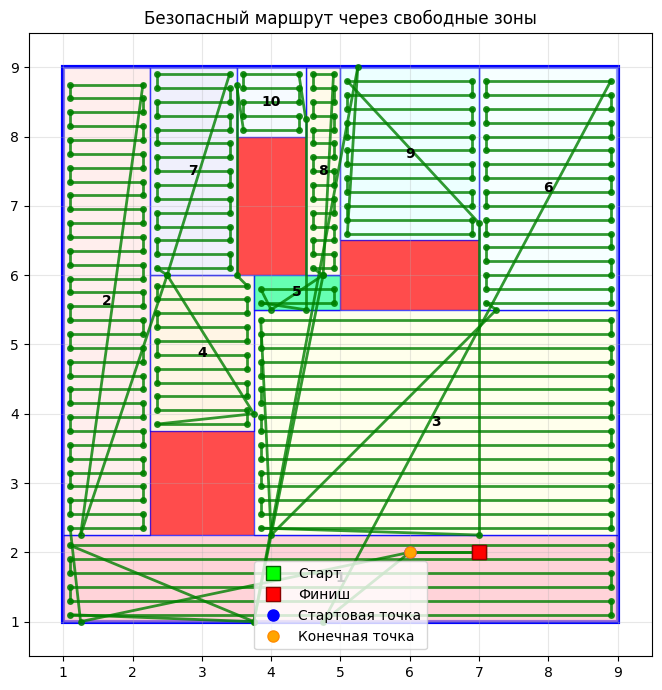

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from typing import List, Tuple
import random

class Point:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Point({self.x:.2f}, {self.y:.2f})"

class FreeZone:
    def __init__(self, vertices: List[Point]):
        self.vertices = vertices
        self.bbox = self._calculate_bbox()
        self.center = self._calculate_center()

    def _calculate_bbox(self) -> Tuple[float, float, float, float]:
        x_coords = [v.x for v in self.vertices]
        y_coords = [v.y for v in self.vertices]
        return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    def _calculate_center(self) -> Point:
        x1, y1, x2, y2 = self.bbox
        return Point((x1 + x2) / 2, (y1 + y2) / 2)

class Obstacle:
    def __init__(self, vertices: List[Point]):
        self.vertices = vertices
        self.bbox = self._calculate_bbox()

    def _calculate_bbox(self) -> Tuple[float, float, float, float]:
        x_coords = [v.x for v in self.vertices]
        y_coords = [v.y for v in self.vertices]
        return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    @classmethod
    def from_center(cls, center_x: float, center_y: float, width: float, height: float):
        half_w, half_h = width / 2, height / 2
        vertices = [
            Point(center_x - half_w, center_y - half_h),
            Point(center_x + half_w, center_y - half_h),
            Point(center_x + half_w, center_y + half_h),
            Point(center_x - half_w, center_y + half_h)
        ]
        return cls(vertices)

class GeometryUtils:
    @staticmethod
    def point_in_polygon(point: Point, polygon: List[Point]) -> bool:
        x, y = point.x, point.y
        n = len(polygon)
        inside = False
        p1x, p1y = polygon[0].x, polygon[0].y

        for i in range(1, n + 1):
            p2x, p2y = polygon[i % n].x, polygon[i % n].y
            if y > min(p1y, p2y) and y <= max(p1y, p2y) and x <= max(p1x, p2x):
                if p1y != p2y:
                    xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                if p1x == p2x or x <= xinters:
                    inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    @staticmethod
    def lines_intersect(a1: Point, a2: Point, b1: Point, b2: Point) -> bool:
        def ccw(A, B, C):
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)
        return ccw(a1, b1, b2) != ccw(a2, b1, b2) and ccw(a1, a2, b1) != ccw(a1, a2, b2)

    @staticmethod
    def distance(p1: Point, p2: Point) -> float:
        return np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)

class CollisionDetector:
    def __init__(self, obstacles: List[Obstacle], boundary: List[Point]):
        self.obstacles = obstacles
        self.boundary = boundary

    def point_in_obstacle(self, point: Point) -> bool:
        return any(GeometryUtils.point_in_polygon(point, obstacle.vertices)
                   for obstacle in self.obstacles)

    def point_in_boundary(self, point: Point) -> bool:
        return GeometryUtils.point_in_polygon(point, self.boundary)

    def line_intersects_obstacle(self, p1: Point, p2: Point) -> bool:
        if self.point_in_obstacle(p1) or self.point_in_obstacle(p2):
            return True

        for obstacle in self.obstacles:
            vertices = obstacle.vertices
            for i in range(len(vertices)):
                side_p1 = vertices[i]
                side_p2 = vertices[(i + 1) % len(vertices)]
                if GeometryUtils.lines_intersect(p1, p2, side_p1, side_p2):
                    return True
        return False

class SpacePartitioner:
    def __init__(self, boundary: List[Point], grid_step: float):
        self.boundary = boundary
        self.grid_step = grid_step
        self.bbox = self._calculate_bbox()

    def _calculate_bbox(self) -> Tuple[float, float, float, float]:
        x_coords = [v.x for v in self.boundary]
        y_coords = [v.y for v in self.boundary]
        return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    def partition_space(self, obstacles: List[Obstacle]) -> List[FreeZone]:
        x1, y1, x2, y2 = self.bbox
        x_coords = np.arange(x1, x2 + self.grid_step, self.grid_step)
        y_coords = np.arange(y1, y2 + self.grid_step, self.grid_step)

        collision_detector = CollisionDetector(obstacles, self.boundary)
        grid = np.zeros((len(y_coords)-1, len(x_coords)-1), dtype=bool)
        visited = np.zeros_like(grid)
        zones = []

        for i in range(len(x_coords)-1):
            for j in range(len(y_coords)-1):
                cell_center = Point((x_coords[i] + x_coords[i+1])/2, (y_coords[j] + y_coords[j+1])/2)
                if not collision_detector.point_in_boundary(cell_center) or collision_detector.point_in_obstacle(cell_center):
                    grid[j, i] = True

        for j in range(len(y_coords)-1):
            i = 0
            while i < len(x_coords)-1:
                if visited[j, i] or grid[j, i]:
                    i += 1
                    continue

                width = 1
                while i + width < len(x_coords)-1 and not visited[j, i + width] and not grid[j, i + width]:
                    width += 1

                height = 1
                can_extend = True
                while can_extend and j + height < len(y_coords)-1:
                    for w in range(width):
                        if visited[j + height, i + w] or grid[j + height, i + w]:
                            can_extend = False
                            break
                    if can_extend:
                        height += 1

                vertices = [
                    Point(x_coords[i], y_coords[j]),
                    Point(x_coords[i + width], y_coords[j]),
                    Point(x_coords[i + width], y_coords[j + height]),
                    Point(x_coords[i], y_coords[j + height])
                ]
                zones.append(FreeZone(vertices))

                for h in range(height):
                    for w in range(width):
                        if j + h < len(y_coords)-1 and i + w < len(x_coords)-1:
                            visited[j + h, i + w] = True
                i += width

        return zones

class SnakePlanner:
    def __init__(self, border_offset: float, step_y: float):
        self.border_offset = border_offset
        self.step_y = step_y

    def generate_trajectory(self, zone: FreeZone) -> List[Point]:
        x1, y1, x2, y2 = zone.bbox
        x_coords = [x1 + self.border_offset, x2 - self.border_offset]
        y_coords = np.arange(y1 + self.border_offset, y2 - self.border_offset, self.step_y)

        if len(y_coords) == 0:
            return [zone.center]

        points = []
        for i, y in enumerate(y_coords):
            if i % 2 == 0:
                points.extend([Point(x, y) for x in x_coords])
            else:
                points.extend([Point(x, y) for x in reversed(x_coords)])
        return points

class ZoneConnector:
    def __init__(self, collision_detector: CollisionDetector, boundary_step: float):
        self.collision_detector = collision_detector
        self.boundary_step = boundary_step

    def get_boundary_points(self, zone: FreeZone) -> List[Point]:
        x1, y1, x2, y2 = zone.bbox
        points = []
        points.extend([Point(x, y1) for x in np.arange(x1 + self.boundary_step/2, x2, self.boundary_step)])
        points.extend([Point(x2, y) for y in np.arange(y1 + self.boundary_step/2, y2, self.boundary_step)])
        points.extend([Point(x, y2) for x in np.arange(x2 - self.boundary_step/2, x1, -self.boundary_step)])
        points.extend([Point(x1, y) for y in np.arange(y2 - self.boundary_step/2, y1, -self.boundary_step)])
        return points

    def find_connection_points(self, zone1: FreeZone, zone2: FreeZone) -> Tuple[Point, Point]:
        boundary1 = self.get_boundary_points(zone1)
        boundary2 = self.get_boundary_points(zone2)

        for p1 in boundary1:
            for p2 in boundary2:
                if not self.collision_detector.line_intersects_obstacle(p1, p2):
                    return p1, p2
        return None

    def find_connection_to_zone(self, point: Point, zone: FreeZone) -> Point:
        boundary_points = self.get_boundary_points(zone)
        for bp in boundary_points:
            if not self.collision_detector.line_intersects_obstacle(point, bp):
                return bp
        return None

class PathPlanner:
    def __init__(self, zones: List[FreeZone], obstacles: List[Obstacle],
                 boundary: List[Point], start: Point, end: Point,
                 start_waypoints: List[Point] = None, end_waypoints: List[Point] = None,
                 border_offset: float = 0.1, step_y: float = 0.2, boundary_step: float = 0.5):
        self.zones = zones
        self.start = start
        self.end = end
        self.start_waypoints = start_waypoints or []
        self.end_waypoints = end_waypoints or []
        self.collision_detector = CollisionDetector(obstacles, boundary)
        self.zone_connector = ZoneConnector(self.collision_detector, boundary_step)
        self.snake_planner = SnakePlanner(border_offset, step_y)

    def _find_closest_zone(self, point: Point) -> FreeZone:
        return min(self.zones, key=lambda z: GeometryUtils.distance(point, z.center)) if self.zones else None

    def build_complete_path(self) -> List[Point]:
        if not self.zones:
            return []

        sorted_zones = sorted(self.zones, key=lambda z: (z.center.x, z.center.y))
        path = [self.start]
        path.extend(self.start_waypoints)

        last_point = path[-1]
        start_zone = self._find_closest_zone(last_point)
        if start_zone:
            connection = self.zone_connector.find_connection_to_zone(last_point, start_zone)
            if connection:
                path.append(connection)

        for i, zone in enumerate(sorted_zones):
            snake_path = self.snake_planner.generate_trajectory(zone)

            if i == 0:
                path.extend(snake_path)
            else:
                prev_zone = sorted_zones[i-1]
                connection = self.zone_connector.find_connection_points(prev_zone, zone)
                if connection:
                    path.extend([connection[0], connection[1]])
                path.extend(snake_path)

        if path:
            last_path_point = path[-1]
            end_zone = self._find_closest_zone(self.end_waypoints[0] if self.end_waypoints else self.end)
            if end_zone:
                end_connection = self.zone_connector.find_connection_to_zone(last_path_point, end_zone)
                if end_connection:
                    path.append(end_connection)

        path.extend(self.end_waypoints)
        path.append(self.end)
        return path

class Visualizer:
    def __init__(self, boundary: List[Point], figsize: Tuple[float, float], colors: List[str]):
        self.boundary = boundary
        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.colors = colors

    def plot_scene(self, zones: List[FreeZone], obstacles: List[Obstacle],
                   path: List[Point], start: Point, end: Point,
                   start_waypoints: List[Point], end_waypoints: List[Point]):
        self.ax.clear()

        boundary_vertices = [[v.x, v.y] for v in self.boundary]
        self.ax.add_patch(Polygon(boundary_vertices, fill=False, edgecolor='blue', linewidth=3))

        for obstacle in obstacles:
            obstacle_vertices = [[v.x, v.y] for v in obstacle.vertices]
            self.ax.add_patch(Polygon(obstacle_vertices, fill=True, facecolor='red', alpha=0.7))

        for i, zone in enumerate(zones):
            zone_vertices = [[v.x, v.y] for v in zone.vertices]
            color = self.colors[i % len(self.colors)]
            self.ax.add_patch(Polygon(zone_vertices, fill=True, facecolor=color, alpha=0.6))
            self.ax.add_patch(Polygon(zone_vertices, fill=False, edgecolor='blue', linewidth=1, alpha=0.7))
            self.ax.text(zone.center.x, zone.center.y, str(i+1), ha='center', va='center', fontweight='bold')

        if len(path) > 1:
            path_x, path_y = [p.x for p in path], [p.y for p in path]
            for i in range(len(path) - 1):
                self.ax.plot([path_x[i], path_x[i+1]], [path_y[i], path_y[i+1]], 'green', linewidth=2, alpha=0.8)
            self.ax.plot(path_x, path_y, 'go', markersize=4, alpha=0.8)

        self.ax.plot(start.x, start.y, 's', markersize=10, markerfacecolor='lime', markeredgecolor='darkgreen', label='Старт')
        self.ax.plot(end.x, end.y, 's', markersize=10, markerfacecolor='red', markeredgecolor='darkred', label='Финиш')

        for wp in start_waypoints:
            self.ax.plot(wp.x, wp.y, 'bo', markersize=8, label='Стартовая точка')
        for wp in end_waypoints:
            self.ax.plot(wp.x, wp.y, 'o', markersize=8, markerfacecolor='orange', markeredgecolor='darkorange', label='Конечная точка')

        x_coords, y_coords = [v.x for v in self.boundary], [v.y for v in self.boundary]
        margin = 0.5
        self.ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
        self.ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_title('Безопасный маршрут через свободные зоны')
        self.ax.legend()

    def show(self):
        plt.tight_layout()
        plt.show()

def main():
    # Константы настроек
    GRID_STEP = 0.25 # шаг сетки для разбиения пространства
    BORDER_OFFSET = 0.1  # отступ от границ зоны для траектории змейки
    STEP_Y = 0.2 # шаг по Y для траектории змейки
    BOUNDARY_STEP = 0.5 # шаг для генерации точек на границе зон
    FIG_SIZE = (7, 7) # размер фигуры для визуализации

    # список цветов для заливки зон
    COLORS = [
      'lightblue', 'lightsteelblue', 'aliceblue', 'lavender', 'azure',
      'lightcyan', 'paleturquoise', 'mintcream', 'honeydew', 'lightgreen',
      'palegreen', 'springgreen', 'lightyellow', 'lemonchiffon', 'cornsilk',
      'blanchedalmond', 'bisque', 'lightpink', 'lavenderblush', 'mistyrose',
      'peachpuff', 'papayawhip', 'seashell', 'snow', 'whitesmoke'
    ]

    # Перемешиваем цвета для более разнообразного распределения
    random.shuffle(COLORS)

    # Конфигурация сцены
    boundary = [Point(1, 1), Point(1, 9), Point(9, 9), Point(9, 1)]
    obstacles = [
        Obstacle.from_center(3, 3, 1.5, 1.5),
        Obstacle.from_center(6, 6, 2.0, 1.0),
        Obstacle.from_center(4, 7, 1.0, 2.0),
    ]

    start_point = Point(7.0, 2.0)
    end_point = Point(7.0, 2.0)
    start_waypoints = [Point(6.0, 2.0)]
    end_waypoints = [Point(6.0, 2.0)]

    # Разбиение пространства на зоны
    partitioner = SpacePartitioner(boundary, GRID_STEP)
    zones = partitioner.partition_space(obstacles)

    # Планирование пути
    path_planner = PathPlanner(
        zones, obstacles, boundary, start_point, end_point,
        start_waypoints, end_waypoints, BORDER_OFFSET, STEP_Y, BOUNDARY_STEP
    )
    path = path_planner.build_complete_path()

    # Визуализация
    visualizer = Visualizer(boundary, FIG_SIZE, COLORS)
    visualizer.plot_scene(zones, obstacles, path, start_point, end_point, start_waypoints, end_waypoints)
    visualizer.show()

if __name__ == "__main__":
    main()

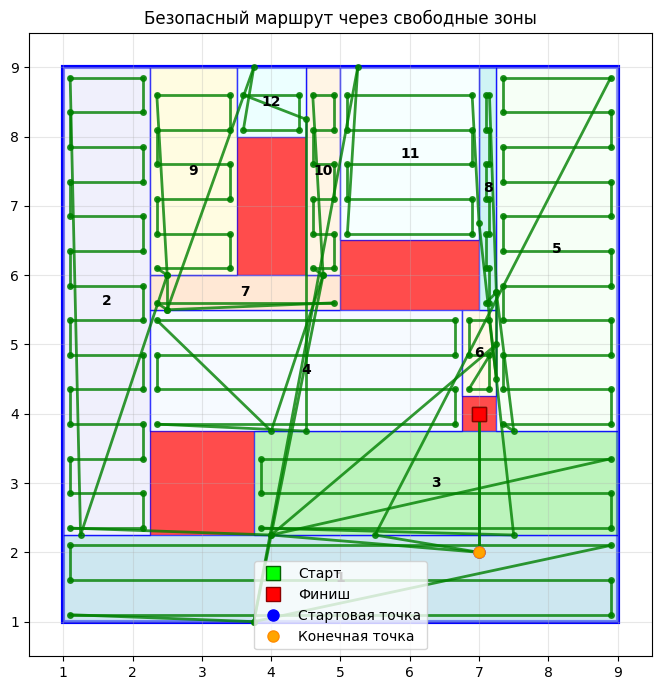

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from typing import List, Tuple, Optional
import random

class Point:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y

    def __repr__(self):
        return f"Point({self.x:.2f}, {self.y:.2f})"

class FreeZone:
    def __init__(self, vertices: List[Point]):
        self.vertices = vertices
        self.bbox = self._calculate_bbox()
        self.center = self._calculate_center()

    def _calculate_bbox(self) -> Tuple[float, float, float, float]:
        x_coords = [v.x for v in self.vertices]
        y_coords = [v.y for v in self.vertices]
        return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    def _calculate_center(self) -> Point:
        x1, y1, x2, y2 = self.bbox
        return Point((x1 + x2) / 2, (y1 + y2) / 2)

class Obstacle:
    def __init__(self, vertices: List[Point]):
        self.vertices = vertices
        self.bbox = self._calculate_bbox()

    def _calculate_bbox(self) -> Tuple[float, float, float, float]:
        x_coords = [v.x for v in self.vertices]
        y_coords = [v.y for v in self.vertices]
        return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    @classmethod
    def from_center(cls, center_x: float, center_y: float, width: float, height: float):
        half_w, half_h = width / 2, height / 2
        vertices = [
            Point(center_x - half_w, center_y - half_h),
            Point(center_x + half_w, center_y - half_h),
            Point(center_x + half_w, center_y + half_h),
            Point(center_x - half_w, center_y + half_h)
        ]
        return cls(vertices)

class GeometryUtils:
    @staticmethod
    def point_in_polygon(point: Point, polygon: List[Point]) -> bool:
        x, y = point.x, point.y
        n = len(polygon)
        inside = False
        p1x, p1y = polygon[0].x, polygon[0].y

        for i in range(1, n + 1):
            p2x, p2y = polygon[i % n].x, polygon[i % n].y
            if y > min(p1y, p2y) and y <= max(p1y, p2y) and x <= max(p1x, p2x):
                if p1y != p2y:
                    xinters = (y - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
                if p1x == p2x or x <= xinters:
                    inside = not inside
            p1x, p1y = p2x, p2y
        return inside

    @staticmethod
    def lines_intersect(a1: Point, a2: Point, b1: Point, b2: Point) -> bool:
        def ccw(A, B, C):
            return (C.y - A.y) * (B.x - A.x) > (B.y - A.y) * (C.x - A.x)
        return ccw(a1, b1, b2) != ccw(a2, b1, b2) and ccw(a1, a2, b1) != ccw(a1, a2, b2)

    @staticmethod
    def distance(p1: Point, p2: Point) -> float:
        return np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)

class CollisionDetector:
    def __init__(self, obstacles: List[Obstacle], boundary: List[Point]):
        self.obstacles = obstacles
        self.boundary = boundary

    def point_in_obstacle(self, point: Point) -> bool:
        return any(GeometryUtils.point_in_polygon(point, obstacle.vertices)
                   for obstacle in self.obstacles)

    def point_in_boundary(self, point: Point) -> bool:
        return GeometryUtils.point_in_polygon(point, self.boundary)

    def line_intersects_obstacle(self, p1: Point, p2: Point) -> bool:
        if self.point_in_obstacle(p1) or self.point_in_obstacle(p2):
            return True

        for obstacle in self.obstacles:
            vertices = obstacle.vertices
            for i in range(len(vertices)):
                side_p1 = vertices[i]
                side_p2 = vertices[(i + 1) % len(vertices)]
                if GeometryUtils.lines_intersect(p1, p2, side_p1, side_p2):
                    return True
        return False

class SpacePartitioner:
    def __init__(self, boundary: List[Point], grid_step: float):
        self.boundary = boundary
        self.grid_step = grid_step
        self.bbox = self._calculate_bbox()

    def _calculate_bbox(self) -> Tuple[float, float, float, float]:
        x_coords = [v.x for v in self.boundary]
        y_coords = [v.y for v in self.boundary]
        return min(x_coords), min(y_coords), max(x_coords), max(y_coords)

    def partition_space(self, obstacles: List[Obstacle]) -> List[FreeZone]:
        x1, y1, x2, y2 = self.bbox
        x_coords = np.arange(x1, x2 + self.grid_step, self.grid_step)
        y_coords = np.arange(y1, y2 + self.grid_step, self.grid_step)

        collision_detector = CollisionDetector(obstacles, self.boundary)
        grid = np.zeros((len(y_coords)-1, len(x_coords)-1), dtype=bool)
        visited = np.zeros_like(grid)
        zones = []

        for i in range(len(x_coords)-1):
            for j in range(len(y_coords)-1):
                cell_center = Point((x_coords[i] + x_coords[i+1])/2, (y_coords[j] + y_coords[j+1])/2)
                if not collision_detector.point_in_boundary(cell_center) or collision_detector.point_in_obstacle(cell_center):
                    grid[j, i] = True

        for j in range(len(y_coords)-1):
            i = 0
            while i < len(x_coords)-1:
                if visited[j, i] or grid[j, i]:
                    i += 1
                    continue

                width = 1
                while i + width < len(x_coords)-1 and not visited[j, i + width] and not grid[j, i + width]:
                    width += 1

                height = 1
                can_extend = True
                while can_extend and j + height < len(y_coords)-1:
                    for w in range(width):
                        if visited[j + height, i + w] or grid[j + height, i + w]:
                            can_extend = False
                            break
                    if can_extend:
                        height += 1

                vertices = [
                    Point(x_coords[i], y_coords[j]),
                    Point(x_coords[i + width], y_coords[j]),
                    Point(x_coords[i + width], y_coords[j + height]),
                    Point(x_coords[i], y_coords[j + height])
                ]
                zones.append(FreeZone(vertices))

                for h in range(height):
                    for w in range(width):
                        if j + h < len(y_coords)-1 and i + w < len(x_coords)-1:
                            visited[j + h, i + w] = True
                i += width

        return zones

class SnakePlanner:
    def __init__(self, border_offset: float, step_y: float):
        self.border_offset = border_offset
        self.step_y = step_y

    def generate_trajectory(self, zone: FreeZone) -> List[Point]:
        x1, y1, x2, y2 = zone.bbox
        x_coords = [x1 + self.border_offset, x2 - self.border_offset]
        y_coords = np.arange(y1 + self.border_offset, y2 - self.border_offset, self.step_y)

        if len(y_coords) == 0:
            return [zone.center]

        points = []
        for i, y in enumerate(y_coords):
            if i % 2 == 0:
                points.extend([Point(x, y) for x in x_coords])
            else:
                points.extend([Point(x, y) for x in reversed(x_coords)])
        return points

class ZoneConnector:
    def __init__(self, collision_detector: CollisionDetector, boundary_step: float):
        self.collision_detector = collision_detector
        self.boundary_step = boundary_step

    def get_boundary_points(self, zone: FreeZone) -> List[Point]:
        x1, y1, x2, y2 = zone.bbox
        points = []
        points.extend([Point(x, y1) for x in np.arange(x1 + self.boundary_step/2, x2, self.boundary_step)])
        points.extend([Point(x2, y) for y in np.arange(y1 + self.boundary_step/2, y2, self.boundary_step)])
        points.extend([Point(x, y2) for x in np.arange(x2 - self.boundary_step/2, x1, -self.boundary_step)])
        points.extend([Point(x1, y) for y in np.arange(y2 - self.boundary_step/2, y1, -self.boundary_step)])
        return points

    def find_connection_points(self, zone1: FreeZone, zone2: FreeZone) -> Optional[Tuple[Point, Point]]:
        boundary1 = self.get_boundary_points(zone1)
        boundary2 = self.get_boundary_points(zone2)

        for p1 in boundary1:
            for p2 in boundary2:
                if not self.collision_detector.line_intersects_obstacle(p1, p2):
                    return p1, p2
        return None

    def find_connection_to_zone(self, point: Point, zone: FreeZone) -> Optional[Point]:
        boundary_points = self.get_boundary_points(zone)
        for bp in boundary_points:
            if not self.collision_detector.line_intersects_obstacle(point, bp):
                return bp
        return None

class PathPlanner:
    def __init__(self, zones: List[FreeZone], obstacles: List[Obstacle],
                 boundary: List[Point], start: Point, end: Point,
                 start_waypoints: List[Point] = None, end_waypoints: List[Point] = None,
                 border_offset: float = 0.1, step_y: float = 0.2, boundary_step: float = 0.5):
        self.zones = zones
        self.start = start
        self.end = end
        self.start_waypoints = start_waypoints or []
        self.end_waypoints = end_waypoints or []
        self.collision_detector = CollisionDetector(obstacles, boundary)
        self.zone_connector = ZoneConnector(self.collision_detector, boundary_step)
        self.snake_planner = SnakePlanner(border_offset, step_y)

    def _find_closest_zone(self, point: Point) -> Optional[FreeZone]:
        return min(self.zones, key=lambda z: GeometryUtils.distance(point, z.center)) if self.zones else None

    def build_complete_path(self) -> List[Point]:
        if not self.zones:
            return []

        sorted_zones = sorted(self.zones, key=lambda z: (z.center.x, z.center.y))
        path = [self.start]
        path.extend(self.start_waypoints)

        last_point = path[-1]
        start_zone = self._find_closest_zone(last_point)
        if start_zone:
            connection = self.zone_connector.find_connection_to_zone(last_point, start_zone)
            if connection:
                path.append(connection)

        for i, zone in enumerate(sorted_zones):
            snake_path = self.snake_planner.generate_trajectory(zone)

            if i == 0:
                path.extend(snake_path)
            else:
                prev_zone = sorted_zones[i-1]
                connection = self.zone_connector.find_connection_points(prev_zone, zone)
                if connection:
                    path.extend([connection[0], connection[1]])
                path.extend(snake_path)

        if path:
            last_path_point = path[-1]
            end_zone = self._find_closest_zone(self.end_waypoints[0] if self.end_waypoints else self.end)
            if end_zone:
                end_connection = self.zone_connector.find_connection_to_zone(last_path_point, end_zone)
                if end_connection:
                    path.append(end_connection)

        path.extend(self.end_waypoints)
        path.append(self.end)
        return path

class Visualizer:
    def __init__(self, boundary: List[Point], figsize: Tuple[float, float], colors: List[str]):
        self.boundary = boundary
        self.fig, self.ax = plt.subplots(figsize=figsize)
        self.colors = colors

    def plot_scene(self, zones: List[FreeZone], obstacles: List[Obstacle],
                   path: List[Point], start: Point, end: Point,
                   start_waypoints: List[Point], end_waypoints: List[Point]):
        self.ax.clear()

        boundary_vertices = [[v.x, v.y] for v in self.boundary]
        self.ax.add_patch(Polygon(boundary_vertices, fill=False, edgecolor='blue', linewidth=3))

        for obstacle in obstacles:
            obstacle_vertices = [[v.x, v.y] for v in obstacle.vertices]
            self.ax.add_patch(Polygon(obstacle_vertices, fill=True, facecolor='red', alpha=0.7))

        for i, zone in enumerate(zones):
            zone_vertices = [[v.x, v.y] for v in zone.vertices]
            color = self.colors[i % len(self.colors)]
            self.ax.add_patch(Polygon(zone_vertices, fill=True, facecolor=color, alpha=0.6))
            self.ax.add_patch(Polygon(zone_vertices, fill=False, edgecolor='blue', linewidth=1, alpha=0.7))
            self.ax.text(zone.center.x, zone.center.y, str(i+1), ha='center', va='center', fontweight='bold')

        if len(path) > 1:
            path_x, path_y = [p.x for p in path], [p.y for p in path]
            for i in range(len(path) - 1):
                self.ax.plot([path_x[i], path_x[i+1]], [path_y[i], path_y[i+1]], 'green', linewidth=2, alpha=0.8)
            self.ax.plot(path_x, path_y, 'go', markersize=4, alpha=0.8)

        self.ax.plot(start.x, start.y, 's', markersize=10, markerfacecolor='lime', markeredgecolor='darkgreen', label='Старт')
        self.ax.plot(end.x, end.y, 's', markersize=10, markerfacecolor='red', markeredgecolor='darkred', label='Финиш')

        # Исправлено: убрано дублирование легенды
        if start_waypoints:
            self.ax.plot(start_waypoints[0].x, start_waypoints[0].y, 'bo', markersize=8, label='Стартовая точка')
            for wp in start_waypoints[1:]:
                self.ax.plot(wp.x, wp.y, 'bo', markersize=8)

        if end_waypoints:
            self.ax.plot(end_waypoints[0].x, end_waypoints[0].y, 'o', markersize=8, markerfacecolor='orange', markeredgecolor='darkorange', label='Конечная точка')
            for wp in end_waypoints[1:]:
                self.ax.plot(wp.x, wp.y, 'o', markersize=8, markerfacecolor='orange', markeredgecolor='darkorange')

        x_coords, y_coords = [v.x for v in self.boundary], [v.y for v in self.boundary]
        margin = 0.5
        self.ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
        self.ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
        self.ax.set_aspect('equal')
        self.ax.grid(True, alpha=0.3)
        self.ax.set_title('Безопасный маршрут через свободные зоны')
        self.ax.legend()

    def show(self):
        plt.tight_layout()
        plt.show()

def main():
    # Константы настроек
    GRID_STEP = 0.25 # шаг сетки для разбиения пространства
    BORDER_OFFSET = 0.1  # отступ от границ зоны для траектории змейки
    STEP_Y = 0.5 # шаг по Y для траектории змейки
    BOUNDARY_STEP = 0.5 # шаг для генерации точек на границе зон
    FIG_SIZE = (7, 7) # размер фигуры для визуализации

    # список цветов для заливки зон
    COLORS = [
        'lightpink', 'lavender', 'mistyrose',
        'lightblue', 'powderblue', 'aliceblue',
        'lightyellow', 'lemonchiffon', 'cornsilk',
        'lightgreen', 'honeydew', 'mintcream',
        'lightcyan', 'azure', 'paleturquoise',
        'peachpuff', 'papayawhip', 'blanchedalmond'
    ]
    # Перемешиваем цвета для более разнообразного распределения
    random.shuffle(COLORS)

    # Конфигурация сцены
    boundary = [Point(1, 1), Point(1, 9), Point(9, 9), Point(9, 1)]
    obstacles = [
        Obstacle.from_center(3.0, 3.0, 1.5, 1.5),
        Obstacle.from_center(6.0, 6.0, 2.0, 1.0),
        Obstacle.from_center(4.0, 7.0, 1.0, 2.0),
        Obstacle.from_center(7.0, 4.0, 0.5, 0.5),
    ]

    start_point = Point(7.0, 4.0)
    end_point = Point(7.0, 4.0)
    start_waypoints = [Point(7.0, 2.0)]
    end_waypoints = [Point(7.0, 2.0)]

    # Разбиение пространства на зоны
    partitioner = SpacePartitioner(boundary, GRID_STEP)
    zones = partitioner.partition_space(obstacles)

    # Планирование пути
    path_planner = PathPlanner(
        zones, obstacles, boundary, start_point, end_point,
        start_waypoints, end_waypoints, BORDER_OFFSET, STEP_Y, BOUNDARY_STEP
    )
    path = path_planner.build_complete_path()

    # Визуализация
    visualizer = Visualizer(boundary, FIG_SIZE, COLORS)
    visualizer.plot_scene(zones, obstacles, path, start_point, end_point, start_waypoints, end_waypoints)
    visualizer.show()

if __name__ == "__main__":
    main()